In [1]:
#
import numpy as np
import os, sys

sys.path.insert(0, '/global/homes/q/qmxp55/DESI/bgstargets/py')

from io_ import get_sweep_whole, getBGSbits, flux_to_mag
from io_ import get_random, get_isdesi, get_dict, bgsmask, get_reg, get_svfields, gaiaAEN
from cuts import getGeoCuts, bgsbut
from QA import getStats, flow, mollweide, mycmap, plot_sysdens, overdensity, hexbin

from QA import set_mwd, get_radec_mw
from io_ import get_isdes

import healpy as hp
import astropy.io.fits as fits
import fitsio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib
from astropy.coordinates import SkyCoord
import astropy.units as units
from astropy.table import Table

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [8]:
dr8pix     = '/global/cfs/cdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
dr9mpix = '/global/cfs/cdirs/desi/target/catalogs/dr9m/0.42.0/pixweight/main/resolve/bright/pixweight-bright.fits'

#survey = 'south' #is either south (DECaLS+DES) or north (BASS/MzLS)
version = '0.1.0'
Nranfiles = 1
ranfiledens = 5000 #density of each random file
TotRanDens = Nranfiles * ranfiledens

patch = None #[174., 186., -3., 2.]
reg = 'south' #'south', 'north', 'decals', 'des', 'svfields'
dr = 'dr8'
#version = '2.0'
if dr == 'dr9d': Nranfiles = 20 # because the randoms for dr9d have a density of 100000 = 5000*20
dec_resol_ns = 32.375

filesdir = '/global/cscratch1/sd/qmxp55/bgstargets_output/'
pathdir = '%s%s/clustering' %(filesdir, dr)

# for healpy
if dr[:3] == 'dr8': pixfile = dr8pix
elif dr[:3] == 'dr9': pixfile = dr9mpix
    
hdr          = fits.getheader(pixfile,1)
nside,nest   = hdr['hpxnside'],hdr['hpxnest']
npix         = hp.nside2npix(nside)
pixarea      = hp.nside2pixarea(nside,degrees=True)

## catalogue

In [9]:
#load catalogues
if dr == 'dr9sv': N = 1
else: N = Nranfiles

#CATALOGUE
cat = np.load(filesdir+dr+'/'+version+'/'+'bgstargets'+'.npy')
catinreg = (cat[reg]) & (cat['desi'])
cat = cat[catinreg]
print('CATALOGUE DONE...')

#RANDOMS
ran = np.load(filesdir+dr+'/'+dr+'_random_N'+str(N)+'.npy', mmap_mode='r+')
ran_ex = np.load(filesdir+dr+'/'+'extra_random_N'+str(N)+'_n256.npy', mmap_mode='r+')
raninreg = (ran_ex[reg]) & (ran_ex['desi'])
ran = ran[raninreg]
ran_ex = ran_ex[raninreg]
print('RANDOMS DONE...')

FileNotFoundError: [Errno 2] No such file or directory: '/global/cscratch1/sd/qmxp55/bgstargets_output/dr8/0.1.0/bgstargets.npy'

In [4]:
catinreg = np.ones(len(cat), dtype=bool)
raninreg = np.ones(len(ran), dtype=bool)

In [5]:
#bgsmask = bgsmask()
rancuts = getGeoCuts(ran, randoms=True)

## Get BGS scenarios

In [6]:
#
from cuts import bgsbut
from io_ import bgsmask
import pandas as pd
from astropy.table import Table

from QA import mollweide, mycmap, plot_sysdens
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib

====== Generating HPPIX dict ======
nominal area and density: 	 9587.78 [sq.deg] 	 1428.85 [objects/sq.deg]
====== Computing WEIGHTS ======
nominal weights coeff: 	 b=1, m=0
====== Generating HPPIX dict ======
new_fracs_no_LG area and density: 	 9587.78 [sq.deg] 	 1450.04 [objects/sq.deg]
====== Computing WEIGHTS ======
new_fracs_no_LG weights coeff: 	 b=1, m=0
====== Generating HPPIX dict ======
allmask_no_fracs_no_LG area and density: 	 9587.78 [sq.deg] 	 1455.18 [objects/sq.deg]
====== Computing WEIGHTS ======
allmask_no_fracs_no_LG weights coeff: 	 b=1, m=0


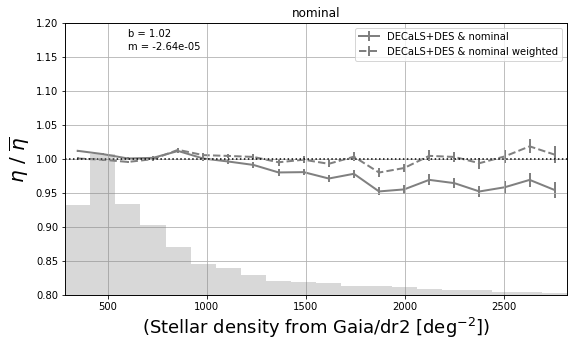

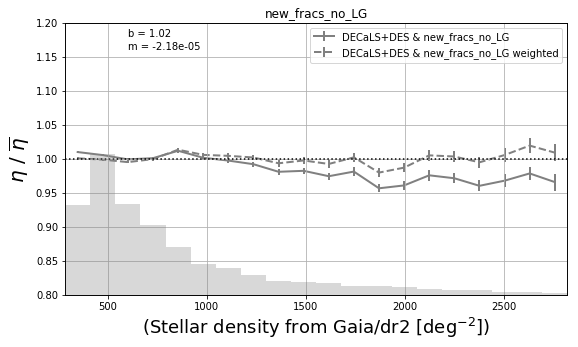

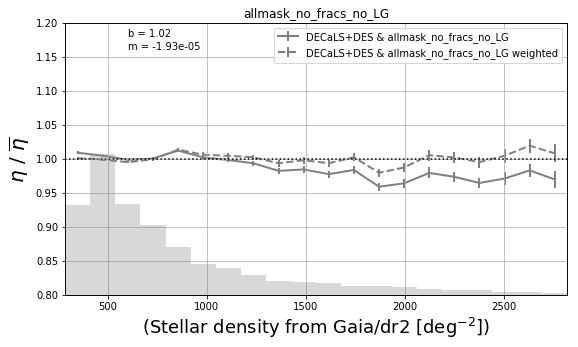

In [7]:
#
bgsbut_fracs_but_lg = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['QC_FM', 'QC_FI', 'QC_FF', 'LG'], bgsmask=bgsmask(), rlimit=20)

fracs_re = np.ones_like(cat, dtype=bool)
for i in (14,15,16): 
    fracs_re &= ((cat['BGSBITS'] & 2**(i)) != 0)

bgs_sce = {}
bgs_sce['nominal'] = ((cat['BGSBITS'] & 2**(20)) != 0)
bgs_sce['new_fracs_no_LG'] = (bgsbut_fracs_but_lg) & (fracs_re)
bgs_sce['allmask_no_fracs_no_LG'] = (bgsbut_fracs_but_lg) & (((cat['BGSBITS'] & 2**(4)) != 0))

#bgs_sce['no_LG_no_fracs'] = bgsbut_fracs_but_lg
#bgs_sce['nominal+ms'] = ((cat['BGSBITS'] & 2**(20)) != 0) & ((cat['BGSBITS'] & 2**(1)) != 0)

ws = {}
sys = {}
sys_w = {}
hpdicts = {}

for key, val in zip(bgs_sce.keys(), bgs_sce.values()):
    
    cati = cat[val]
    #extrai = extra[val]
    catinregi = catinreg[val]
    #catindesii = cat['desi'][val]
    
    if key == 'allmask_no_fracs_no_LG': maskrand = ((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (rancuts['allmask']) & (raninreg))
    elif key == 'nominal+ms': maskrand = ((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (rancuts['MS']) & (raninreg))
    else: maskrand = ((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (raninreg))
        
    print('====== Generating HPPIX dict ======')
    
    #dic with default BGS selection and in DESI footprint
    hpdict = get_dict(cat=cati, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=cati['hppix'], 
                      maskrand=maskrand, maskcat=(catinregi), Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=cati['desi'], 
                                namesels={key:val[val]}, galb=cati['b'], log=False, survey='custom', ranfiledens=ranfiledens)
    
    hpdicts[key] = hpdict
    
    print('%s area and density: \t %.2f [sq.deg] \t %.2f [objects/sq.deg]' %(key, hpdict['bgsarea_%s' %(reg)], hpdict['dens_%s_%s' %(key, reg)]))
    
    print('====== Computing WEIGHTS ======')
    
    isdesi     = (hpdict['isdesi']) & (hpdict['bgsfracarea']>0)
    namesel = key
    syst='stardens'

    fig    = plt.figure(figsize=(9,5))
    gs     = gridspec.GridSpec(1,1,hspace=0.30,wspace=0.25)
    
    b0, m0, sysi, sysi_w = plot_sysdens(hpdicttmp=hpdict, namesels=[namesel], regs=[reg], syst=syst, mainreg=isdesi, xlim=None, n=0, nx=20, 
             clip=True, denslims=False, ylab=True, weights=True, fig=fig, gs=gs, label=True, title=key, overbyreg=True, percentiles=None)

    print('%s weights coeff: \t b=%i, m=%i' %(key, b0, m0))
    
    wsi = 1./((m0)*hpdict['stardens'] + b0)
    ws[key] = wsi
    sys[key] = sysi
    sys_w[key] = sysi_w
    
    if False:
    
        print('====== Assignin WEIGHTS for each target ======')

        %time s = pd.Series(cati['hppix'])
        %time d = s.groupby(s).groups

        DENS = np.zeros_like(cati['RA'])
        WS_north = DENS.copy()
        STARDEN = DENS.copy()

        hpdens = (hpdict['south_n%s' %(key)] + hpdict['north_n%s' %(key)] ) / (pixarea * hpdict['bgsfracarea'])

        for npixid, catids in zip(d.keys(), d.values()):
            DENS[catids] = hpdens[npixid]
            STARDEN[catids] = hpdict['stardens'][npixid]
            WS_north[catids] = wsi[npixid]

        print('====== save to file ======')

        tab = Table()
        cols = ['TYPE','RA','DEC','GMAG','RMAG','ZMAG', 'MASKBITS','BGSBITS']

        for col in cols:
            tab[col] = cati[col]

        for col in ['b','des','decals','north','desi','south']:
            tab[col] = cati[col]

        tab['DENS'] = DENS
        tab['WS_north'] = WS_north
        tab['STARDEN'] = STARDEN
        tab['bgs'] = val[val]

        # save astropy table as npy file
        dest = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/clustering/%s_%s' %(dr, reg, key)
        np.save(dest, tab)
    

In [17]:
del cati, catinregi#, tab

## Flow Charts

In [9]:
hpdict0 = get_dict(cat=None, pixmapfile=pixfile, hppix_ran=ran_ex['hppix'], hppix_cat=None, 
                      maskrand=None, maskcat=None, Nranfiles=Nranfiles, ranindesi=ran_ex['desi'], catindesi=None, 
                            desifootprint=True, namesels=None, target_outputs=False, log=True)

positions and desifotprint DONE...
systematics DONE...
randdens =  15000  ; len randoms =  68240287
bgsfracarea DONE...
regions DONE...
area_all = 4549 deg2
bgsarea_south = 0 deg2
bgsarea_decals = 0 deg2
bgsarea_des = 0 deg2
bgsarea_north = 4549 deg2
bgsarea_south_n = 0 deg2
bgsarea_south_s = 0 deg2
bgsarea_svfields = 201 deg2
bgsarea_svfields_n = 201 deg2
bgsarea_svfields_s = 0 deg2
areas DONE...


In [10]:
if reg == 'south': surveylab = 'DECaLS+DES'
elif reg == 'north': surveylab = 'BASS_MzLS'
elif reg == 'desi': surveylab = 'DESI'
else: surveylab = reg

#this is important to read the area of the proper region in hpdict0
region = reg

In [11]:
#
for key, val in zip(bgs_sce.keys(), bgs_sce.values()):

    if key == 'nominal':
        order = [['SG'], ['BS', 'LG', 'GC'], ['nobs'], ['FMC2','CC'], ['QC_FM', 'QC_FI', 'QC_FF']]
    elif key == 'new_fracs_no_LG':
        order = [['SG'], ['BS', 'GC'], ['nobs'], ['FMC2','CC'], ['QC_FM2', 'QC_FI2', 'QC_FF2']]
    elif key == 'allmask_no_fracs_no_LG':
        order = [['SG'], ['BS', 'GC'], ['nobs'], ['FMC2','CC'], ['allmask']]
    else:
        raise ValueError('%s has not been defined yet.' %(key))

    flowTitle = '%s_%s_%s' %(dr, surveylab, key)
    flowNominal, _, _ = flow(cat=cat, hpdict=hpdict0, bgsmask=bgsmask(), rancuts=rancuts, order=order, reg=region, 
                 regcat=catinreg, regran=raninreg, file='%s/flow_%s' %(pathdir, flowTitle), dr=flowTitle, program='main')

    flowNominal
    

Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|LG|GC)
Previous Cuts: (SG|BS|LG|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|LG|GC|nobs)
Current Cuts: (FMC2|CC)
Previous Cuts: (SG|BS|LG|GC|nobs|FMC2|CC)
Current Cuts: (QC_FM|QC_FI|QC_FF)
Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|GC)
Previous Cuts: (SG|BS|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|GC|nobs)
Current Cuts: (FMC2|CC)
Previous Cuts: (SG|BS|GC|nobs|FMC2|CC)
Current Cuts: (QC_FM2|QC_FI2|QC_FF2)
Previous Cuts: (None)
Current Cuts: (SG)
Previous Cuts: (SG)
Current Cuts: (BS|GC)
Previous Cuts: (SG|BS|GC)
Current Cuts: (nobs)
Previous Cuts: (SG|BS|GC|nobs)
Current Cuts: (FMC2|CC)
Previous Cuts: (SG|BS|GC|nobs|FMC2|CC)
Current Cuts: (allmask)


## Get RANDOMS for BGS scenarios with STARDENS

In [8]:
# match associated target density for each object

s = pd.Series(ran_ex['hppix'])
d = s.groupby(s).groups

STARDEN_ran = np.zeros_like(ran['RA'])

#
for npixid, catids in zip(d.keys(), d.values()):
    STARDEN_ran[catids] = hpdicts['nominal']['stardens'][npixid]


In [9]:
#
maskrands = {'nominal':((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs'])),
             'nominal+allmask':((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (rancuts['allmask'])),
             #'nominal+ms': ((rancuts['BS']) & (rancuts['GC']) & (rancuts['nobs']) & (rancuts['MS']))
            }

for key, val in zip(maskrands.keys(), maskrands.values()):
    
    tabran = Table()

    mask = val

    tabran['RA'], tabran['DEC'] = ran['RA'][mask], ran['DEC'][mask]
    tabran['MASKBITS'] = ran['MASKBITS'][mask]

    for col in ['b','des','decals','north','desi','south']:
        tabran[col] = ran_ex[col][mask]

    tabran['STARDEN'] = STARDEN_ran[mask]

    # save astropy table as npy file
    dest = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/clustering/randoms%i_%s_%s' %(dr, N, reg, key)
    np.save(dest, tabran)
    

In [19]:
#fix permissions
#chgrp -R desi  /global/cscratch1/sd/qmxp55/bgstargets_output/dr9m
#chmod -R g+rX  /global/cscratch1/sd/qmxp55/bgstargets_output/dr9m

Variable              Type          Data/Info
---------------------------------------------
DENS                  ndarray       6494781: 6494781 elems, type `float64`, 51958248 bytes (49.551246643066406 Mb)
N                     int           3
Nranfiles             int           3
STARDEN               ndarray       6494781: 6494781 elems, type `float64`, 51958248 bytes (49.551246643066406 Mb)
STARDEN_ran           memmap        [ 876.92785645  247.82743<...>70014954\n  781.60961914]
SkyCoord              ABCMeta       <class 'astropy.coordinat<...>sky_coordinate.SkyCoord'>
Table                 type          <class 'astropy.table.table.Table'>
TotRanDens            int           15000
WS_north              ndarray       6494781: 6494781 elems, type `float64`, 51958248 bytes (49.551246643066406 Mb)
b0                    float64       0.9898924756034334
bgs_sce               dict          n=5
bgsbut                function      <function bgsbut at 0x2aaadfc85400>
bgsbut_fracs_but_lg   

# Sanity checks

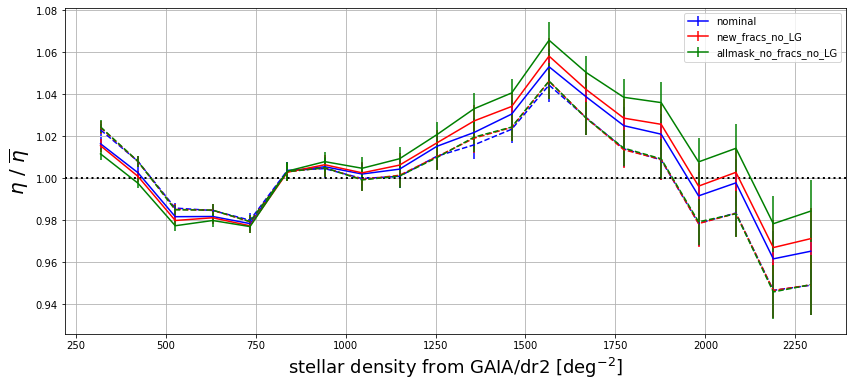

In [12]:
#
#stacking systematics
fig = plt.figure(figsize=(14,6))
colors = ['blue', 'red', 'green', 'k', 'orange']
for num, key in enumerate(sys.keys()):
    
    plt.errorbar(sys[key][0], sys[key][1], sys[key][2], ls='-', color=colors[num], label=key)
    plt.errorbar(sys_w[key][0], sys_w[key][1], sys_w[key][2], ls='--', color=colors[num])
    
plt.axhline(1, ls=':', c='k', lw=2)
plt.ylabel(r'$\eta$ / $\overline{\eta}$',fontsize=20)
plt.xlabel('stellar density from GAIA/dr2 [deg$^{-2}$]',fontsize=18)
plt.grid()
plt.legend()

fig.savefig('%s/stellar_dens_syst_%s.png' %(pathdir, reg), bbox_inches = 'tight', pad_inches = 0)


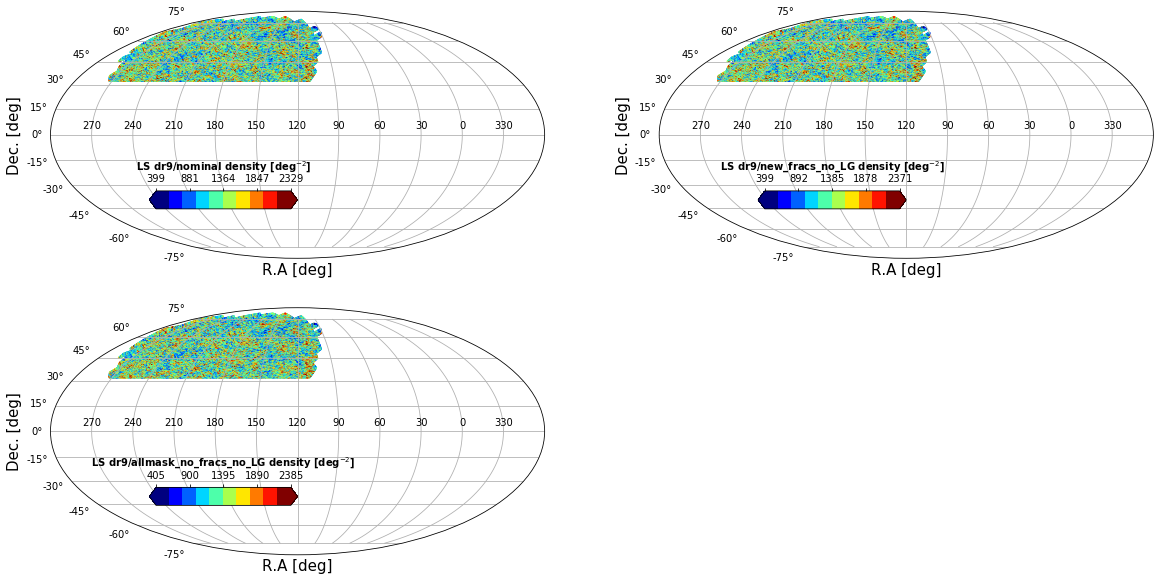

In [13]:
#witbgs_scets
keys = list(bgs_sce.keys())
c = 2
r = len(keys)//c + 1
fig = plt.figure(figsize=(10*c, 5*r))
gs = gridspec.GridSpec(r,c)
    
org          = 120  # centre ra for mollweide plots
projection   = 'mollweide'
cm = mycmap(matplotlib.cm.jet, 10,0,1)
cmr= mycmap(matplotlib.cm.jet_r,10,0,1)
    
for num, key, val in zip(range(len(hpdicts.keys())), hpdicts.keys(), hpdicts.values()):
    
    #plt.title(r'%s' %(key), size=18)
    mollweide(hpdict=val, namesel=key, reg=reg, projection=projection, n=num, org=org, cm=cm, fig=fig, gs=gs, cval=None, dr=dr)

fig.savefig('%s/skymap_dens_%s.png' %(pathdir, reg), bbox_inches = 'tight', pad_inches = 0)

In [14]:
#
tabran = np.load('%s/randoms_%s_nominal.npy' %(pathdir, reg))

plt.figure(figsize=(20,10))

mask2 = tabran['STARDEN'] < 1000
maskn = (tabran[reg]) & (tabran['desi'])
N = 200

plt.scatter(tabran['RA'][::N], tabran['DEC'][::N], s=0.5, c='gray', label='all %s' %(reg))
plt.scatter(tabran['RA'][maskn][::N], tabran['DEC'][maskn][::N], s=0.5, c='r', label=surveylab)

plt.title('RANDOMS catalogue', size=20)

lgnd = plt.legend()
[handle.set_sizes([50]) for handle in lgnd.legendHandles]

plt.xlabel(r'R.A.', size=15)
plt.ylabel(r'Dec.', size=15)

FileNotFoundError: [Errno 2] No such file or directory: '/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/randoms_north_nominal.npy'

In [ ]:
del tabran

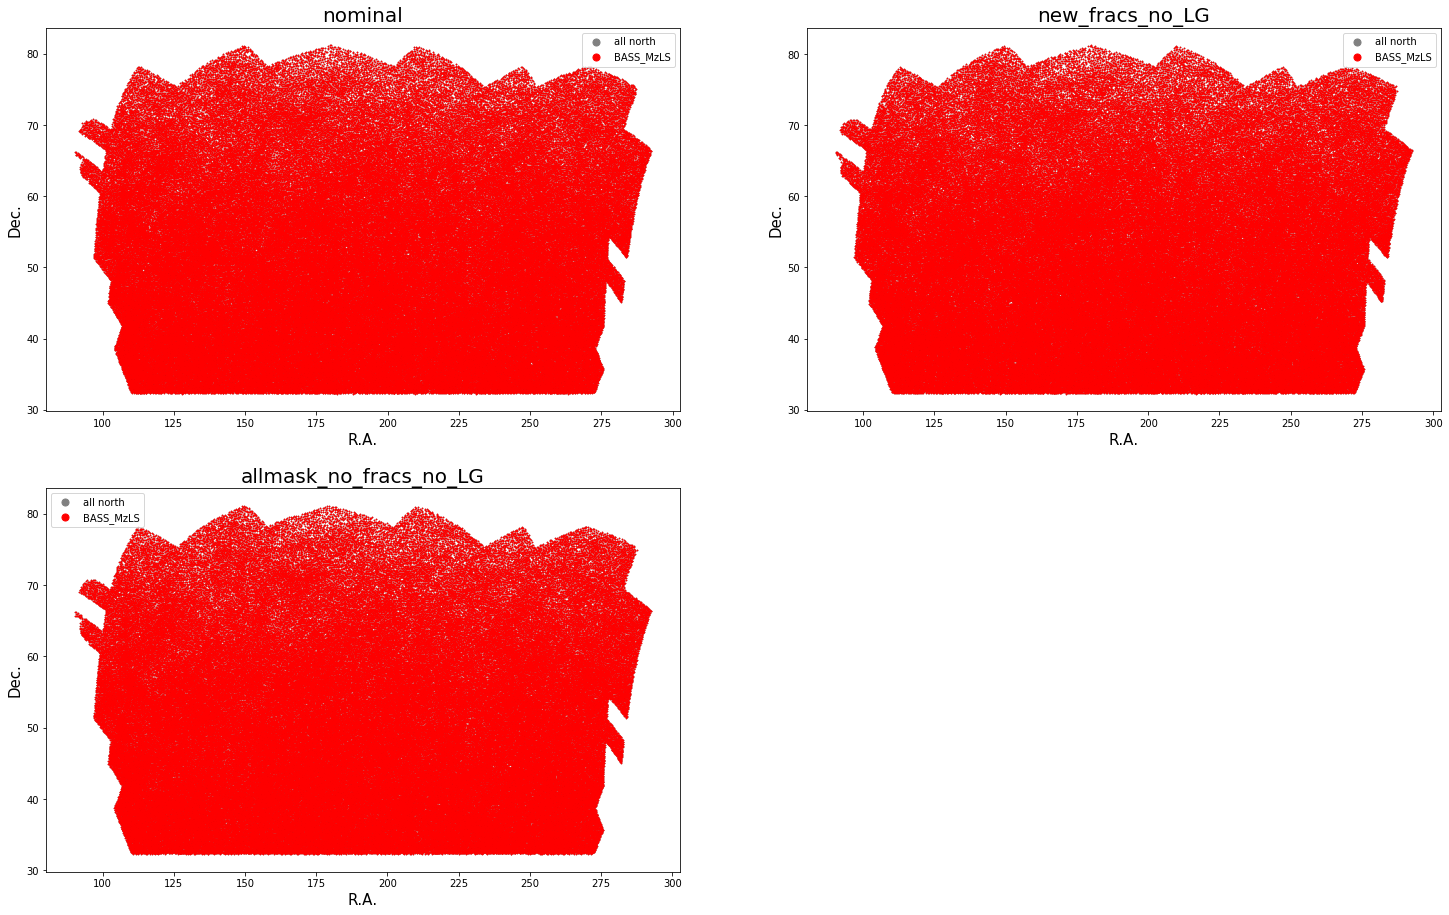

In [18]:
plt.figure(figsize=(25,24))

for num, key in enumerate(bgs_sce.keys()):
    
    tab = np.load('%s/%s_%s.npy' %(pathdir, reg, key))

    N = 30
    mask2 = tab['STARDEN'] < 1000
    maskn = (tab[reg]) & (tab['desi'])

    plt.subplot(3,2,num+1)
    plt.scatter(tab['RA'][::N], tab['DEC'][::N], s=0.5, c='gray', label='all %s' %(reg))
    plt.scatter(tab['RA'][maskn][::N], tab['DEC'][maskn][::N], s=0.5, c='r', label=surveylab)

    plt.title(r'%s' %(key), size=20)

    lgnd = plt.legend()
    [handle.set_sizes([50]) for handle in lgnd.legendHandles]

    plt.xlabel(r'R.A.', size=15)
    plt.ylabel(r'Dec.', size=15)


In [19]:
del tab

In [25]:
for num, key in enumerate(bgs_sce.keys()):
    print(key)

nominal
new_fracs_no_LG
allmask_no_fracs_no_LG


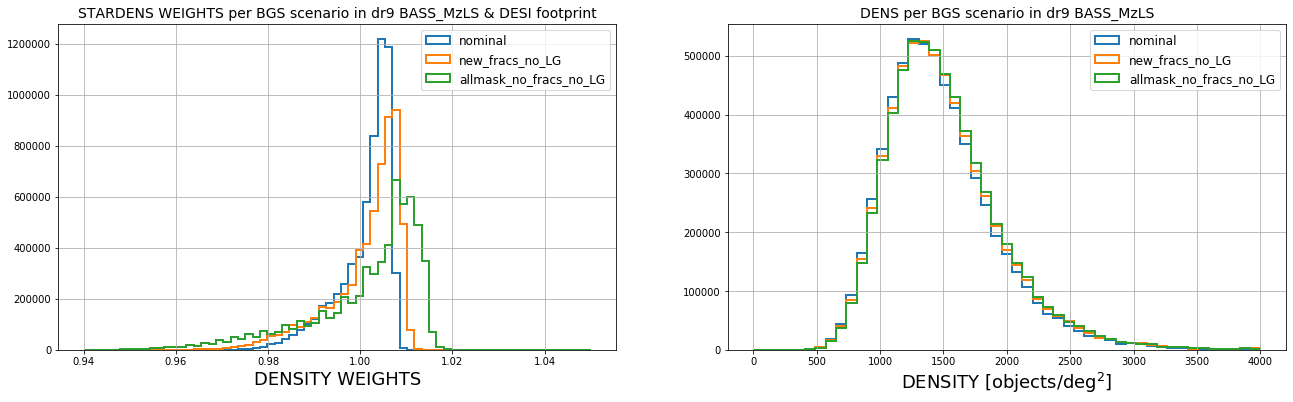

In [20]:
#
fig = plt.figure(figsize=(22, 6))

for num, key in enumerate(bgs_sce.keys()):
    
    tab = np.load('%s/%s_%s.npy' %(pathdir, reg, key))
    mask = (tab[reg]) & (tab['desi'])
    finite = np.isfinite(tab['DENS'])

    bins = np.linspace(.94, 1.05, 70)
    bins2 = np.linspace(0, 4000, 50)
    
    plt.subplot(1,2,1)
    plt.title('STARDENS WEIGHTS per BGS scenario in %s %s & DESI footprint' %(dr, surveylab), size=14)
    plt.hist(tab['WS_north'][mask], bins=bins, histtype='step', lw=2, label=key)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xlabel(r'DENSITY WEIGHTS', size=18)
    
    plt.subplot(1,2,2)
    plt.title('DENS per BGS scenario in %s %s' %(dr, surveylab), size=14)
    plt.hist(tab['DENS'][(mask) & (finite)], bins=bins2, histtype='step', lw=2, label=key)
    plt.legend(fontsize=12)
    plt.grid()
    plt.xlabel(r'DENSITY [objects/deg$^{2}$]', size=18)
    
fig.savefig('%s/weights_%s.png' %(pathdir, reg), bbox_inches = 'tight', pad_inches = 0)
    

# 2D stacks around the Large Galaxies

In [21]:
sga = fitsio.read('/global/cfs/cdirs/cosmo/staging/largegalaxies/v3.0/SGA-ellipse-v3.0.fits')
lg = (sga['SGA_ID'] > 0)
#gal_svfields = get_custom_svfields(sga['RA'], sga['DEC'], survey=survey)
sga = sga[(lg)]

### BGS withou the LG mask

mag_bins_len: 1
12.00 < MAG_LEDA < 20.00
MARK #1
MARK #2
mag_radii MAX: 165.62325 mag_radii MIN: 1.0118619
mag MAX: 19.999 mag MIN: 12.023
d2d min= 0, d2d max=988
6121495 6121495 6121495
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-3.76, 0.188)
1 of inf in density ratio out of a total of 7556
Minimum density ratio = -4.93266, Maximum density ratio = 0.822226
----------------


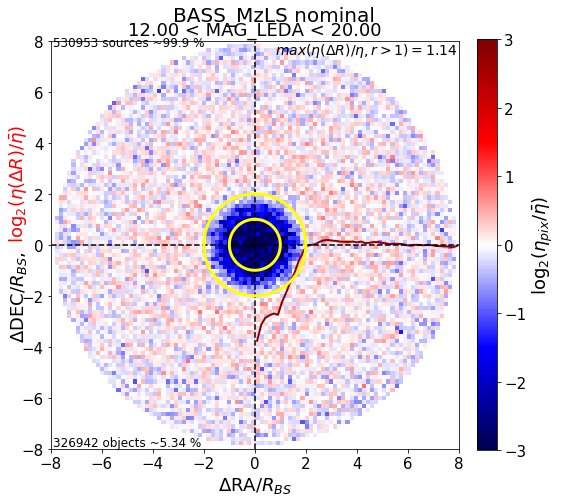

mag_bins_len: 1
12.00 < MAG_LEDA < 20.00
MARK #1
MARK #2
mag_radii MAX: 165.62325 mag_radii MIN: 1.0118619
mag MAX: 19.999 mag MIN: 12.023
d2d min= 0, d2d max=988
6212952 6212952 6212952
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-0.213, 1.8)
0 of inf in density ratio out of a total of 7556
Minimum density ratio = -1.38827, Maximum density ratio = 2.0912
----------------


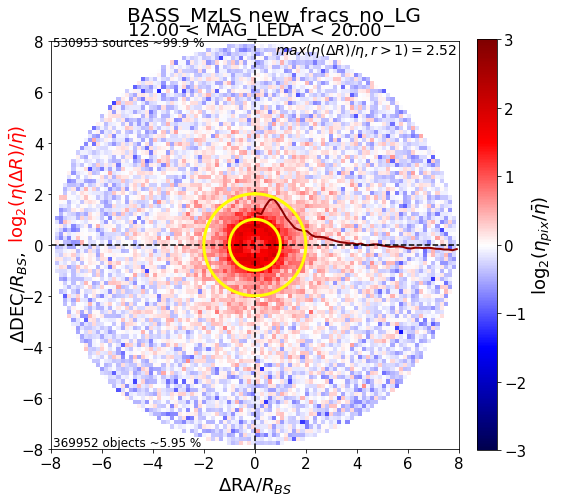

mag_bins_len: 1
12.00 < MAG_LEDA < 20.00
MARK #1
MARK #2
mag_radii MAX: 165.62325 mag_radii MIN: 1.0118619
mag MAX: 19.999 mag MIN: 12.023
d2d min= 0, d2d max=988
6260264 6260264 6260264
density cumu (min, max): (nan, nan)
density non-cumu (min, max): (-0.215, 1.84)
0 of inf in density ratio out of a total of 7556
Minimum density ratio = -1.4012, Maximum density ratio = 2.10782
----------------


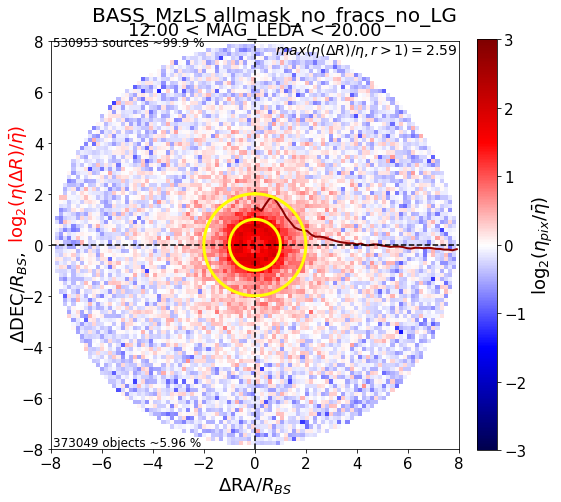

In [22]:
              
for key, val in bgs_sce.items():
    
    filename = os.path.join(pathdir, '2Dstacks_LG_%s_%s' %(reg, key))

    log = True
    nbins = 101
    
    plt.figure(figsize=(8,8))
    plt.title(r'%s %s' %(surveylab, key), size=20)
    plt.axis('off')
    
    gal_radii = sga['BA_LEDA'] * sga['D25_LEDA'] * 60 * 1/2
    
    d2d2, d_ra2, d_dec2, annMask = overdensity(cat=cat[val], star=sga, radii_1=None, slitw=35, nameMag='MAG_LEDA', magbins=[12,20], grid=[1,1], SR=[1., 1000.], 
                                               scaling=True, nbins=nbins, SR_scaling=8,logDenRat=[-3, 3], radii_bestfit=False, annulus=[1.0, 2.0], bintype='0', 
                                                   filename=filename, log=log, gal_radii=gal_radii)
    plt.show()
    

# Repeating above with 2X the BS masking radii of DR9

- [X] Create the `maskbitsources` file.

```python

patch = None
maskbitsources = get_sweep_whole(patch=patch, dr='%s-%s' %(dr, reg), rlimit=None, maskbitsource=True, bgsbits=False, 
                opt='2', sweepdir='/global/cscratch1/sd/qmxp55/bgstargets_output/%s/' %(dr))
```


- [X] get the BS stars
- [] mask arond them for master catalogue (cat) and randoms (randoms). If this take a long time, save files to dr9 output directory
- [] Run script to generate the catalogues for the different scenariis and the randoms as well.
- [] generate the plots.
    

In [4]:
maskbitsources = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/%s/%s-%s_sweep_whole_maskbitsource.npy' 
                         %(dr, dr, reg), mmap_mode='r+')

In [5]:
from io_ import get_bsmask
stars = get_bsmask(maskbitsources)

1769 nearby objects
450307 Bright Stars


In [6]:
#np.save('/global/cscratch1/sd/qmxp55/bgstargets_output/%s/stars_TYCHO_GAIA_13' %(dr), stars)

In [24]:
#
hppix = hp.ang2pix(nside,(90.-stars['DEC'])*np.pi/180.,stars['RA']*np.pi/180.,nest=True)
print('healpix DONE...')
stars_desi = get_reg(reg='desi', hppix=hppix)
stars_reg = get_reg(reg=reg, hppix=hppix)


healpix DONE...


In [25]:
#Dustin_radii's
mag = np.linspace(0, 20, 50)
BS_radii = [] #DR8
new_BS_radii = [] #DR9
for i,j in enumerate(mag):
    BS_radii.append([j, np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])
    new_BS_radii.append([j, 0.5 * np.minimum(1800., 150. * 2.5**((11. - j)/3.)) * 0.262/1])

### Use code below to check footprint in catalogue and star catalogue

```python
plt.figure(figsize=(20, 12))
sm = (stars_desi) & (stars_reg)
cm = (catindesi) & (catinreg)

plt.subplot(2,1,1)
plt.scatter(cat['RA'][cm][::20], cat['DEC'][cm][::20], s=1, label='cat')

plt.subplot(2,1,2)
plt.scatter(stars['RA'][sm][::5], stars['DEC'][sm][::5], s=1, label='stars')
```

### Use code below to get custom masking around Bright Stars in Catalogue and Randoms
Approx run time for catalogue is $\sim 200$ sec, and $\sim 1000$ sec for randoms.

```python 
#
from QA import circular_mask_radii_func
from io_ import query_catalog_mask

#=====================================
#==== Custom masking on CATALOGUE ====
#=====================================

BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)
#
new_BS_t = query_catalog_mask(cat['RA'], cat['DEC'], stars, new_BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=True, bestfit=False, log=False)

#masking radius for each object cloosest stars in cat
mask_radii = circular_mask_radii_func(BS_t[1]['w1_source'], BS_radii, bestfit=False)
#masking radius reescaled for each object
mask_radii_res = BS_t[1]['d2d_source']/mask_radii

tab = Table()
tab['dr8'] = BS_t[0]
tab['dr9'] = new_BS_t[0]

file_cat_radiis = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/%s-%s_custom_radi_catalogue.npy' %(dr, dr, reg)
np.save(file_cat_radiis, tab)

#=====================================
#==== Custom masking on RANDOMS ======
#=====================================

BS_t_ran = query_catalog_mask(randoms['RA'], randoms['DEC'], stars, BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=False, bestfit=False, log=False)
#
new_BS_t_ran = query_catalog_mask(randoms['RA'], randoms['DEC'], stars, new_BS_radii, nameMag='MAG', diff_spikes=False, 
                             length_radii=None, widht_radii=None, return_diagnostics=False, bestfit=False, log=False)


tab_ran = Table()
tab_ran['dr8'] = BS_t_ran
tab_ran['dr9'] = new_BS_t_ran

file_ran_radiis = '/global/cscratch1/sd/qmxp55/bgstargets_output/%s/%s-%s_custom_radi_randoms.npy' %(dr, dr, reg)
np.save(file_ran_radiis, tab_ran)
```

In [65]:
sm = (stars_desi) & (stars_reg)
cm = (catindesi) & (catinreg)
bgsbut_bs = bgsbut(bgsbits=cat['BGSBITS'], rmag=cat['RMAG'], pop=['BS'], bgsmask=bgsmask(), rlimit=20)
BS = (cat['MASKBITS'] & 2**1)!=0

In [66]:
print('Tot. masked by Custom DR8 radii: \t %i '%(BS_t[0][cm].sum()))
print('Tot. masked by Custom DR9 radii: \t %i '%(new_BS_t[0][cm].sum()))
print('Tot. masked by official DR9 radii: \t %i '%(BS[cm].sum()))
print('--------')
print('Missed by Custom DR9: \t %i' %(((BS) & (~new_BS_t[0]) & (cm)).sum()))
print('\t of which in BGS: \t %i' %(((BS) & (~new_BS_t[0]) & (cm) & (bgsbut_bs)).sum()))

Tot. masked by Custom DR8 radii: 	 1795737 
Tot. masked by Custom DR9 radii: 	 759151 
Tot. masked by official DR9 radii: 	 815348 
--------
Missed by Custom DR9: 	 59604
	 of which in BGS: 	 3883


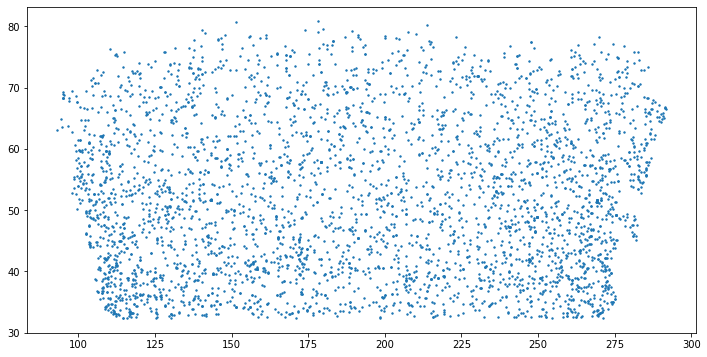

In [67]:
from cuts import bgsbut
plt.figure(figsize=(12,6))

mask =(BS) & (~new_BS_t[0]) & (cm) & (bgsbut_bs)
plt.scatter(cat['RA'][mask], cat['DEC'][mask], s=2, label='cat')

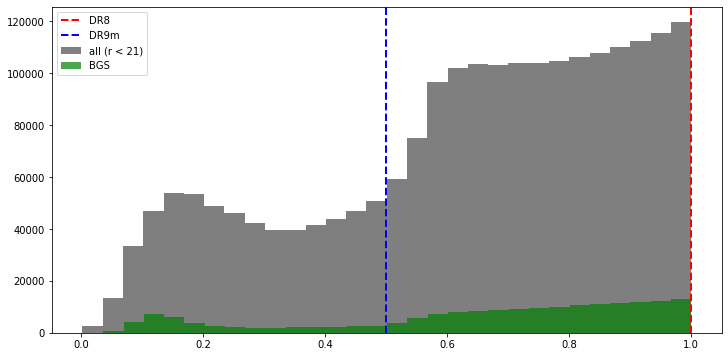

In [62]:
plt.figure(figsize=(12,6))
plt.hist(mask_radii_res[mask_radii_res > 0], 30, alpha=0.5, color='k', label='all (r < 21)')
plt.hist(mask_radii_res[(mask_radii_res > 0) & (bgsbut_bs)], 30, alpha=0.7, color='g', label='BGS')
plt.axvline(1, lw=2, ls='--', color='r', label='DR8')
plt.axvline(0.5, lw=2, ls='--', color='b', label='DR9m')
plt.legend()
plt.show()

Hi all,

Before proceding to generate a catalogue with a custom masking radii around bright stars I want to share I found some differences in the number of rejected objects by official BS mask (the one defined by the `MASKBITS` in the SWEEPS with bit=1) and the custom mask I implemented. In total, using custom masking in DR9m we miss (or we don't mask) 59604 objects that the official masking masks. This represents ~7% out of the total objects masked by the official mask with r < 21. Some numbers below.

Tot. masked by Custom DR9 radii: 	 759151 
Tot. masked by official DR9 radii: 	 815348 
--------
Missed by Custom DR9: 	 59604
	 of which in BGS: 	 3883
     Tot. masked by Custom DR9 radii: 	 759151 
Tot. masked by official DR9 radii: 	 815348 
--------
Missed by Custom DR9: 	 59604
	 of which in BGS: 	 3883
I think we should check this before running any clustering analysis. In plots below we have the sky positions of these 7% missing objects and then we have a histogram of the objects masked by the custom BS mask in gray (objects have the upper limit of r < 21), and in green we have the BGS out of the gray ones, meaning this last ones wont be masked out if using the Custom BS mask. X-axis scale is the distance reescaled to the masking radius to the closest star for each object. Red and blue dashed lines shows the masking radii using in DR8 and in DR9m respectively.